In [1]:
import numpy as np
import xarray as xr
import pickle as pk
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
import scipy.stats as stats
from sklearn.linear_model import LinearRegression as lr 
from sklearn.metrics import r2_score as r2_score
import matplotlib as mpl
mpl.rc('font',size=16,**{'family':'sans-serif','sans-serif':['Arial']})

In [2]:
control = pk.load(open('../Data/Outputs/b.e12.pi-control.T31_g37.ctl.2_diag_grid_int.pk','rb'))
closed = pk.load(open('../Data/Outputs/b.e12.1pyCO2.T31_g37.ctl.closed.2_diag_grid_int.pk','rb'))

In [3]:
ta = closed['ta_int'][:140]
rh = closed['rh_int'][:140]
exp  = 0.286
cmip_plevs = np.asarray([10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000])

pt_closed = np.zeros([140,12,17,48,96])
pt_ctl = np.zeros([30,12,17,48,96])
for i in range(17):
    pt_closed[:,:,i,:,:] = ta[:,:,i,:,:]*(1000/cmip_plevs[i])**exp
    pt_ctl[:,:,i,:,:] = control['ta_int'][-30:,:,i,:,:]*(1000/cmip_plevs[i])**exp


In [4]:
pt_ft_closed = np.nanmean(pt_closed[:,:,7:15,:,:],axis=2)
pt_bl_closed = np.nanmean(pt_closed[:,:,15:,:,:],axis=2)

pt_ft_ctl = np.nanmean(pt_ctl[:,:,7:15,:,:],axis=2)
pt_bl_ctl = np.nanmean(pt_ctl[:,:,15:,:,:],axis=2)

bts_closed = np.mean(pt_ft_closed-pt_bl_closed,axis=1)
bts_ctl = np.tile(np.mean(pt_ft_ctl-pt_bl_ctl,axis=(0,1))[None,:,:],(140,1,1))

In [5]:
lat = control['lat']
trop_ind = np.where(np.logical_and(lat>=-30, lat<=30))
lon = control['lon']
years = np.arange(0,140,1)
y = lat*np.pi/180
coslat = np.cos(y)
coslat = np.tile(coslat[None,:,None],(140,1,lon.size))
trop_weight = np.squeeze(coslat[:,trop_ind,:])

In [6]:
bts_ctl.shape

(140, 48, 96)

In [7]:
trop_bts_closed = np.average(np.squeeze(bts_closed[:,trop_ind,:]),weights=trop_weight,axis=(1,2))
trop_bts_ctl = np.average(np.squeeze(bts_ctl[:,trop_ind,:]),weights=trop_weight,axis=(1,2))

dBTS = trop_bts_closed-trop_bts_ctl

In [8]:
ebp1  = pk.load(open('../Data/Outputs/EB/b.e12.1pyCO2.T31_g37.ctl.closed.2_EB_grid.pk','rb'))
ft_flx = ebp1['cld_sw_hi'][:140]
ft_flx_trop = np.average(np.squeeze(ft_flx[:,trop_ind,:]),weights=trop_weight,axis=(1,2))

relative humidity and surface temperature

In [9]:
rh700_ctl = np.tile(np.nanmean(control['rh_int'][-30:,:,13,:,:],axis=(0,1))[None,:,:],(140,1,1))
rh700_closed = np.nanmean(closed['rh_int'][:140,:,13,:,:],axis=1)

rh700_trop_closed = np.average(np.squeeze(rh700_closed[:,trop_ind,:]),weights=trop_weight,axis=(1,2))
rh700_trop_ctl = np.average(np.squeeze(rh700_ctl[:,trop_ind,:]),weights=trop_weight,axis=(1,2))

dRH700 = rh700_trop_closed-rh700_trop_ctl

In [10]:
tas_ctl = np.tile(np.nanmean(control['tas'][-30:,:,:,:],axis=(0,1))[None,:,:],(140,1,1))
tas_closed = np.nanmean(closed['tas'][:140,:,:,:],axis=1)

tas_trop_closed = np.average(np.squeeze(tas_closed[:,trop_ind,:]),weights=trop_weight,axis=(1,2))
tas_trop_ctl = np.average(np.squeeze(tas_ctl[:,trop_ind,:]),weights=trop_weight,axis=(1,2))

dTAS = tas_trop_closed-tas_trop_ctl

In [11]:
r2_score(ft_flx_trop,dTAS)

-2.7712837522126916

In [12]:
def LinReg_wrap(predictand,predictor):
    fit = lr().fit(predictor,predictand)
    prediction = fit.predict(predictor)
    r2 = r2_score(predictand,prediction)
    return fit.coef_, r2, prediction

In [13]:
slope = {}
r2 = {}
prediction = {}

slope['BTS'], r2['BTS'], prediction['BTS'] = LinReg_wrap(ft_flx_trop,dBTS.reshape(-1,1))
slope['rh'], r2['rh'], prediction['rh'] = LinReg_wrap(ft_flx_trop,dRH700.reshape(-1,1))
slope['sst'], r2['sst'], prediction['sst'] = LinReg_wrap(ft_flx_trop,dTAS.reshape(-1,1))

In [14]:
slope['BTS']

array([-2.25334311])

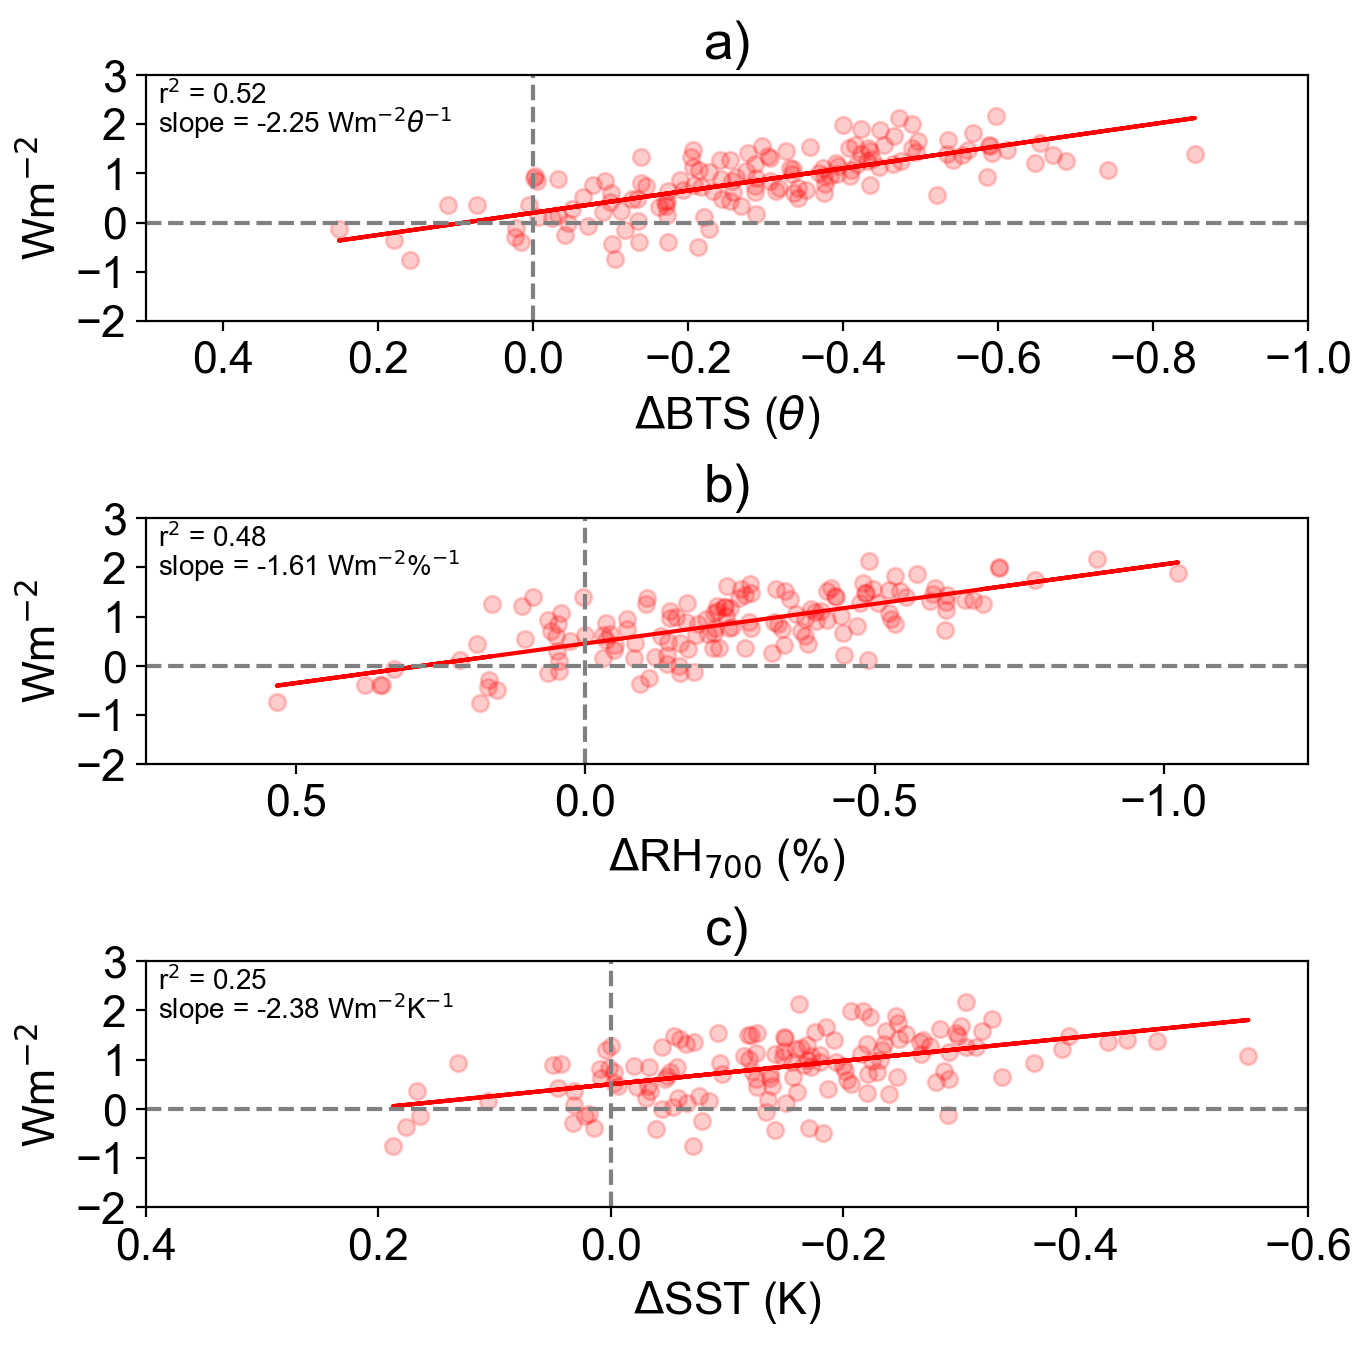

In [17]:
fig, ax = plt.subplots(figsize=(7.5,7.5),dpi=200)

ax1 = plt.subplot(311)
plt.title('a)')
plt.scatter(dBTS,ft_flx_trop, alpha=0.2, color='red')
plt.plot(dBTS,prediction['BTS'],color='red')
plt.axhline(0,color='grey',linestyle = '--')
plt.axvline(0,color='grey',linestyle = '--')
plt.xlim(-1,0.5)
plt.ylim(-2,3)
plt.yticks(np.arange(-2,3.1,1))
plt.ylabel('Wm$^{-2}$')
plt.xlabel('$\Delta$BTS ($\\theta$)')
plt.gca().invert_xaxis()

plt.text(.01, .98, 'r$^{{2}}$ = {}'.format(round(r2['BTS'],2)), ha='left', va='top', fontsize=10,transform=ax1.transAxes)
plt.text(.01, .88, 'slope = {} Wm$^{{-2}}$$\\theta$$^{{-1}}$'.format(round(slope['BTS'][0],2)), ha='left', va='top', fontsize=10,transform=ax1.transAxes)

ax2 = plt.subplot(312)
plt.title('b)')
plt.scatter(dRH700,ft_flx_trop, alpha=0.2, color='red')
plt.plot(dRH700,prediction['rh'],color='red')
plt.axhline(0,color='grey',linestyle = '--')
plt.axvline(0,color='grey',linestyle = '--')
plt.xlim(-1.25,0.76)
plt.ylim(-2,3)
plt.yticks(np.arange(-2,3.1,1))
plt.ylabel('Wm$^{-2}$')
plt.xlabel('$\Delta$RH$_{700}$ (%)')
plt.gca().invert_xaxis()


plt.text(.01, .98, 'r$^{{2}}$ = {}'.format(round(r2['rh'],2)), ha='left', va='top', fontsize=10,transform=ax2.transAxes)
plt.text(.01, .88, 'slope = {} Wm$^{{-2}}$%$^{{-1}}$'.format(round(slope['rh'][0],2)), ha='left', va='top', fontsize=10,transform=ax2.transAxes)

ax3 = plt.subplot(313)
plt.title('c)')
plt.scatter(dTAS,ft_flx_trop, alpha=0.2, color='red')
plt.plot(dTAS,prediction['sst'],color='red')
plt.axhline(0,color='grey',linestyle = '--')
plt.axvline(0,color='grey',linestyle = '--')
plt.xlim(-0.6,0.4)
plt.ylim(-2,3)
plt.yticks(np.arange(-2,3.1,1))
plt.ylabel('Wm$^{-2}$')
plt.xlabel('$\Delta$SST (K)')
plt.gca().invert_xaxis()

plt.text(.01, .98, 'r$^{{2}}$ = {}'.format(round(r2['sst'],2)), ha='left', va='top', fontsize=10,transform=ax3.transAxes)
plt.text(.01, .88, 'slope = {} Wm$^{{-2}}$K$^{{-1}}$'.format(round(slope['sst'][0],2)), ha='left', va='top', fontsize=10,transform=ax3.transAxes)

plt.subplots_adjust(hspace=0.8)

plt.savefig('CCFs.png',bbox_inches='tight')
